In [1]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.warp import reproject, Resampling, calculate_default_transform
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

In [2]:
PATH_WIND = r"/Users/hester/Desktop/data/GBR_power-density_100m.tif"  # 连续
PATH_TRA  = r"/Users/hester/Desktop/data/tra_binary.tif"             # 0/1 + nodata
PATH_ROC  = r"/Users/hester/Desktop/data/roc_binary.tif"             # 0/1 + nodata

OUT_SCORE = r"/Users/hester/Desktop/data/final_weighted_score.tif"
OUT_CLASS = r"/Users/hester/Desktop/data/final_weighted_class.tif"

In [3]:
WORLD_SHP = r"/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
USE_UK = True

In [4]:
DST_CRS = "EPSG:27700"

In [5]:
# 1) AHP：算 3 因子权重 + CR 检验（你同意的经济导向默认值）
#    Criteria order: [Wind, Transmission, Roads]
def build_ahp_matrix_from_pairs(n, pairs):
    A = np.ones((n, n), dtype=float)
    for i, j, aij in pairs:
        A[i, j] = float(aij)
        A[j, i] = 1.0 / float(aij)
    return A

def ahp_weights_cr(A: np.ndarray):
    A = np.array(A, dtype=float)
    n = A.shape[0]

    vals, vecs = np.linalg.eig(A)
    idx = np.argmax(vals.real)
    lam_max = vals.real[idx]
    w = np.abs(vecs[:, idx].real)
    w = w / w.sum()

    CI = (lam_max - n) / (n - 1) if n > 1 else 0.0
    RI_table = {1:0.00, 2:0.00, 3:0.58, 4:0.90, 5:1.12, 6:1.24, 7:1.32, 8:1.41, 9:1.45, 10:1.49}
    RI = RI_table[n]
    CR = (CI / RI) if RI > 0 else 0.0
    return w, lam_max, CI, CR

criteria = ["Wind (energy yield)", "Transmission (grid cost)", "Roads (access)"]

# 你同意的默认：Wind vs Tra=3, Wind vs Roads=5, Tra vs Roads=3
wind_vs_tra  = 3
wind_vs_road = 5
tra_vs_road  = 3

pairs = [
    (0, 1, wind_vs_tra),
    (0, 2, wind_vs_road),
    (1, 2, tra_vs_road),
]
A = build_ahp_matrix_from_pairs(3, pairs)
w, lam_max, CI, CR = ahp_weights_cr(A)

W_WIND, W_TRA, W_ROC = float(w[0]), float(w[1]), float(w[2])

print("AHP weights:")
for c, wi in zip(criteria, w):
    print(f"  {c:26s}: {wi:.4f}")
print(f"CR = {CR:.4f}  ->", "OK (<0.10)" if CR < 0.10 else "NOT OK (adjust pairwise values)")

if CR >= 0.10:
    raise ValueError("AHP consistency CR >= 0.10. Please adjust pairwise judgments.")

AHP weights:
  Wind (energy yield)       : 0.6370
  Transmission (grid cost)  : 0.2583
  Roads (access)            : 0.1047
CR = 0.0332  -> OK (<0.10)


In [6]:
# 2) 对齐工具：把其他栅格对齐到风功率密度的网格（模板）
def align_to_template(src_path, tpl_crs, tpl_transform, tpl_shape,
                      is_categorical=True, dst_nodata=np.nan):
    tpl_h, tpl_w = tpl_shape
    dst = np.full((tpl_h, tpl_w), dst_nodata, dtype="float32")

    with rasterio.open(src_path) as src:
        src_arr = src.read(1).astype("float32")
        src_nodata = src.nodata

        reproject(
            source=src_arr,
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            src_nodata=src_nodata,
            dst_transform=tpl_transform,
            dst_crs=tpl_crs,
            dst_nodata=dst_nodata,
            resampling=Resampling.nearest if is_categorical else Resampling.bilinear
        )

    return dst

In [8]:
def standardize_0_1(x, valid_mask, p_low=2, p_high=98):
    """
    Percentile clipping + min-max normalization to [0,1]
    """
    v = x[valid_mask]
    lo = np.percentile(v, p_low)
    hi = np.percentile(v, p_high)

    y = np.clip(x, lo, hi)
    y = (y - lo) / (hi - lo + 1e-12)
    return y

In [9]:
# 3) 读 Wind + 标准化到 0–1（百分位裁剪 + minmax）
with rasterio.open(PATH_WIND) as src:
    wind_src = src.read(1).astype("float32")
    wind_src_crs = src.crs
    wind_src_transform = src.transform
    wind_src_nodata = src.nodata
    src_h, src_w = src.height, src.width

print("Wind original CRS:", wind_src_crs)
print("Target CRS:", DST_CRS)

# 计算重投影后的网格参数
dst_transform, dst_w, dst_h = calculate_default_transform(
    wind_src_crs, DST_CRS, src_w, src_h, *rasterio.transform.array_bounds(src_h, src_w, wind_src_transform)
)

wind_27700 = np.full((dst_h, dst_w), np.nan, dtype="float32")

reproject(
    source=wind_src,
    destination=wind_27700,
    src_transform=wind_src_transform,
    src_crs=wind_src_crs,
    src_nodata=wind_src_nodata,
    dst_transform=dst_transform,
    dst_crs=DST_CRS,
    dst_nodata=np.nan,
    resampling=Resampling.bilinear
)

# wind 有效掩膜
valid_wind = np.isfinite(wind_27700)
wind01 = np.full_like(wind_27700, np.nan, dtype="float32")
wind01[valid_wind] = standardize_0_1(wind_27700, valid_wind, p_low=2, p_high=98)[valid_wind]

Wind original CRS: EPSG:4326
Target CRS: EPSG:27700


In [10]:
# 1) AHP 权重
criteria = ["Wind (energy yield)", "Transmission (grid cost)", "Roads (access)"]

wind_vs_tra  = 3
wind_vs_road = 5
tra_vs_road  = 3

pairs = [(0, 1, wind_vs_tra), (0, 2, wind_vs_road), (1, 2, tra_vs_road)]
A = build_ahp_matrix_from_pairs(3, pairs)
w, lam_max, CI, CR = ahp_weights_cr(A)

W_WIND, W_TRA, W_ROC = float(w[0]), float(w[1]), float(w[2])

print("AHP weights:")
for c, wi in zip(criteria, w):
    print(f"  {c:26s}: {wi:.4f}")
print(f"CR = {CR:.4f}  ->", "OK (<0.10)" if CR < 0.10 else "NOT OK")

if CR >= 0.10:
    raise ValueError("AHP consistency CR >= 0.10. Please adjust pairwise judgments.")

AHP weights:
  Wind (energy yield)       : 0.6370
  Transmission (grid cost)  : 0.2583
  Roads (access)            : 0.1047
CR = 0.0332  -> OK (<0.10)


In [11]:
# 2) tra / roc 对齐到 wind(27700模板)
tpl_shape = wind_27700.shape
tpl_crs = DST_CRS
tpl_transform = dst_transform

tra = align_to_template(PATH_TRA, tpl_crs, tpl_transform, tpl_shape, is_categorical=True, dst_nodata=np.nan)
roc = align_to_template(PATH_ROC, tpl_crs, tpl_transform, tpl_shape, is_categorical=True, dst_nodata=np.nan)

# 255 / 非有限 -> NaN
for arr in (tra, roc):
    arr[(arr == 255) | (~np.isfinite(arr))] = np.nan

tra01 = np.clip(tra, 0, 1)
roc01 = np.clip(roc, 0, 1)

In [12]:
# 3) WLC 合成
all_valid = np.isfinite(wind01) & np.isfinite(tra01) & np.isfinite(roc01)

score = np.full(tpl_shape, np.nan, dtype="float32")
score[all_valid] = (W_WIND * wind01[all_valid] +
                    W_TRA  * tra01[all_valid] +
                    W_ROC  * roc01[all_valid])

In [13]:
# 4) 输出 GeoTIFF（CRS=27700）
NODATA_OUT = -9999.0
score_out = score.copy()
score_out[~np.isfinite(score_out)] = NODATA_OUT

meta_score = {
    "driver": "GTiff",
    "height": tpl_shape[0],
    "width": tpl_shape[1],
    "count": 1,
    "dtype": "float32",
    "crs": tpl_crs,
    "transform": tpl_transform,
    "nodata": NODATA_OUT,
    "compress": "lzw"
}

with rasterio.open(OUT_SCORE, "w", **meta_score) as dst:
    dst.write(score_out, 1)
print("Saved:", OUT_SCORE)

Saved: /Users/hester/Desktop/data/final_weighted_score.tif


In [14]:
# 5) 分级（4级）
bins = [0.0, 0.25, 0.50, 0.75, 1.00001]
cls = np.full(tpl_shape, 255, dtype="uint8")
cls[all_valid & (score >= bins[0]) & (score <  bins[1])] = 0
cls[all_valid & (score >= bins[1]) & (score <  bins[2])] = 1
cls[all_valid & (score >= bins[2]) & (score <  bins[3])] = 2
cls[all_valid & (score >= bins[3]) & (score <= bins[4])] = 3

meta_cls = meta_score.copy()
meta_cls.update(dtype="uint8", nodata=255)

with rasterio.open(OUT_CLASS, "w", **meta_cls) as dst:
    dst.write(cls, 1)
print("Saved:", OUT_CLASS)

Saved: /Users/hester/Desktop/data/final_weighted_class.tif


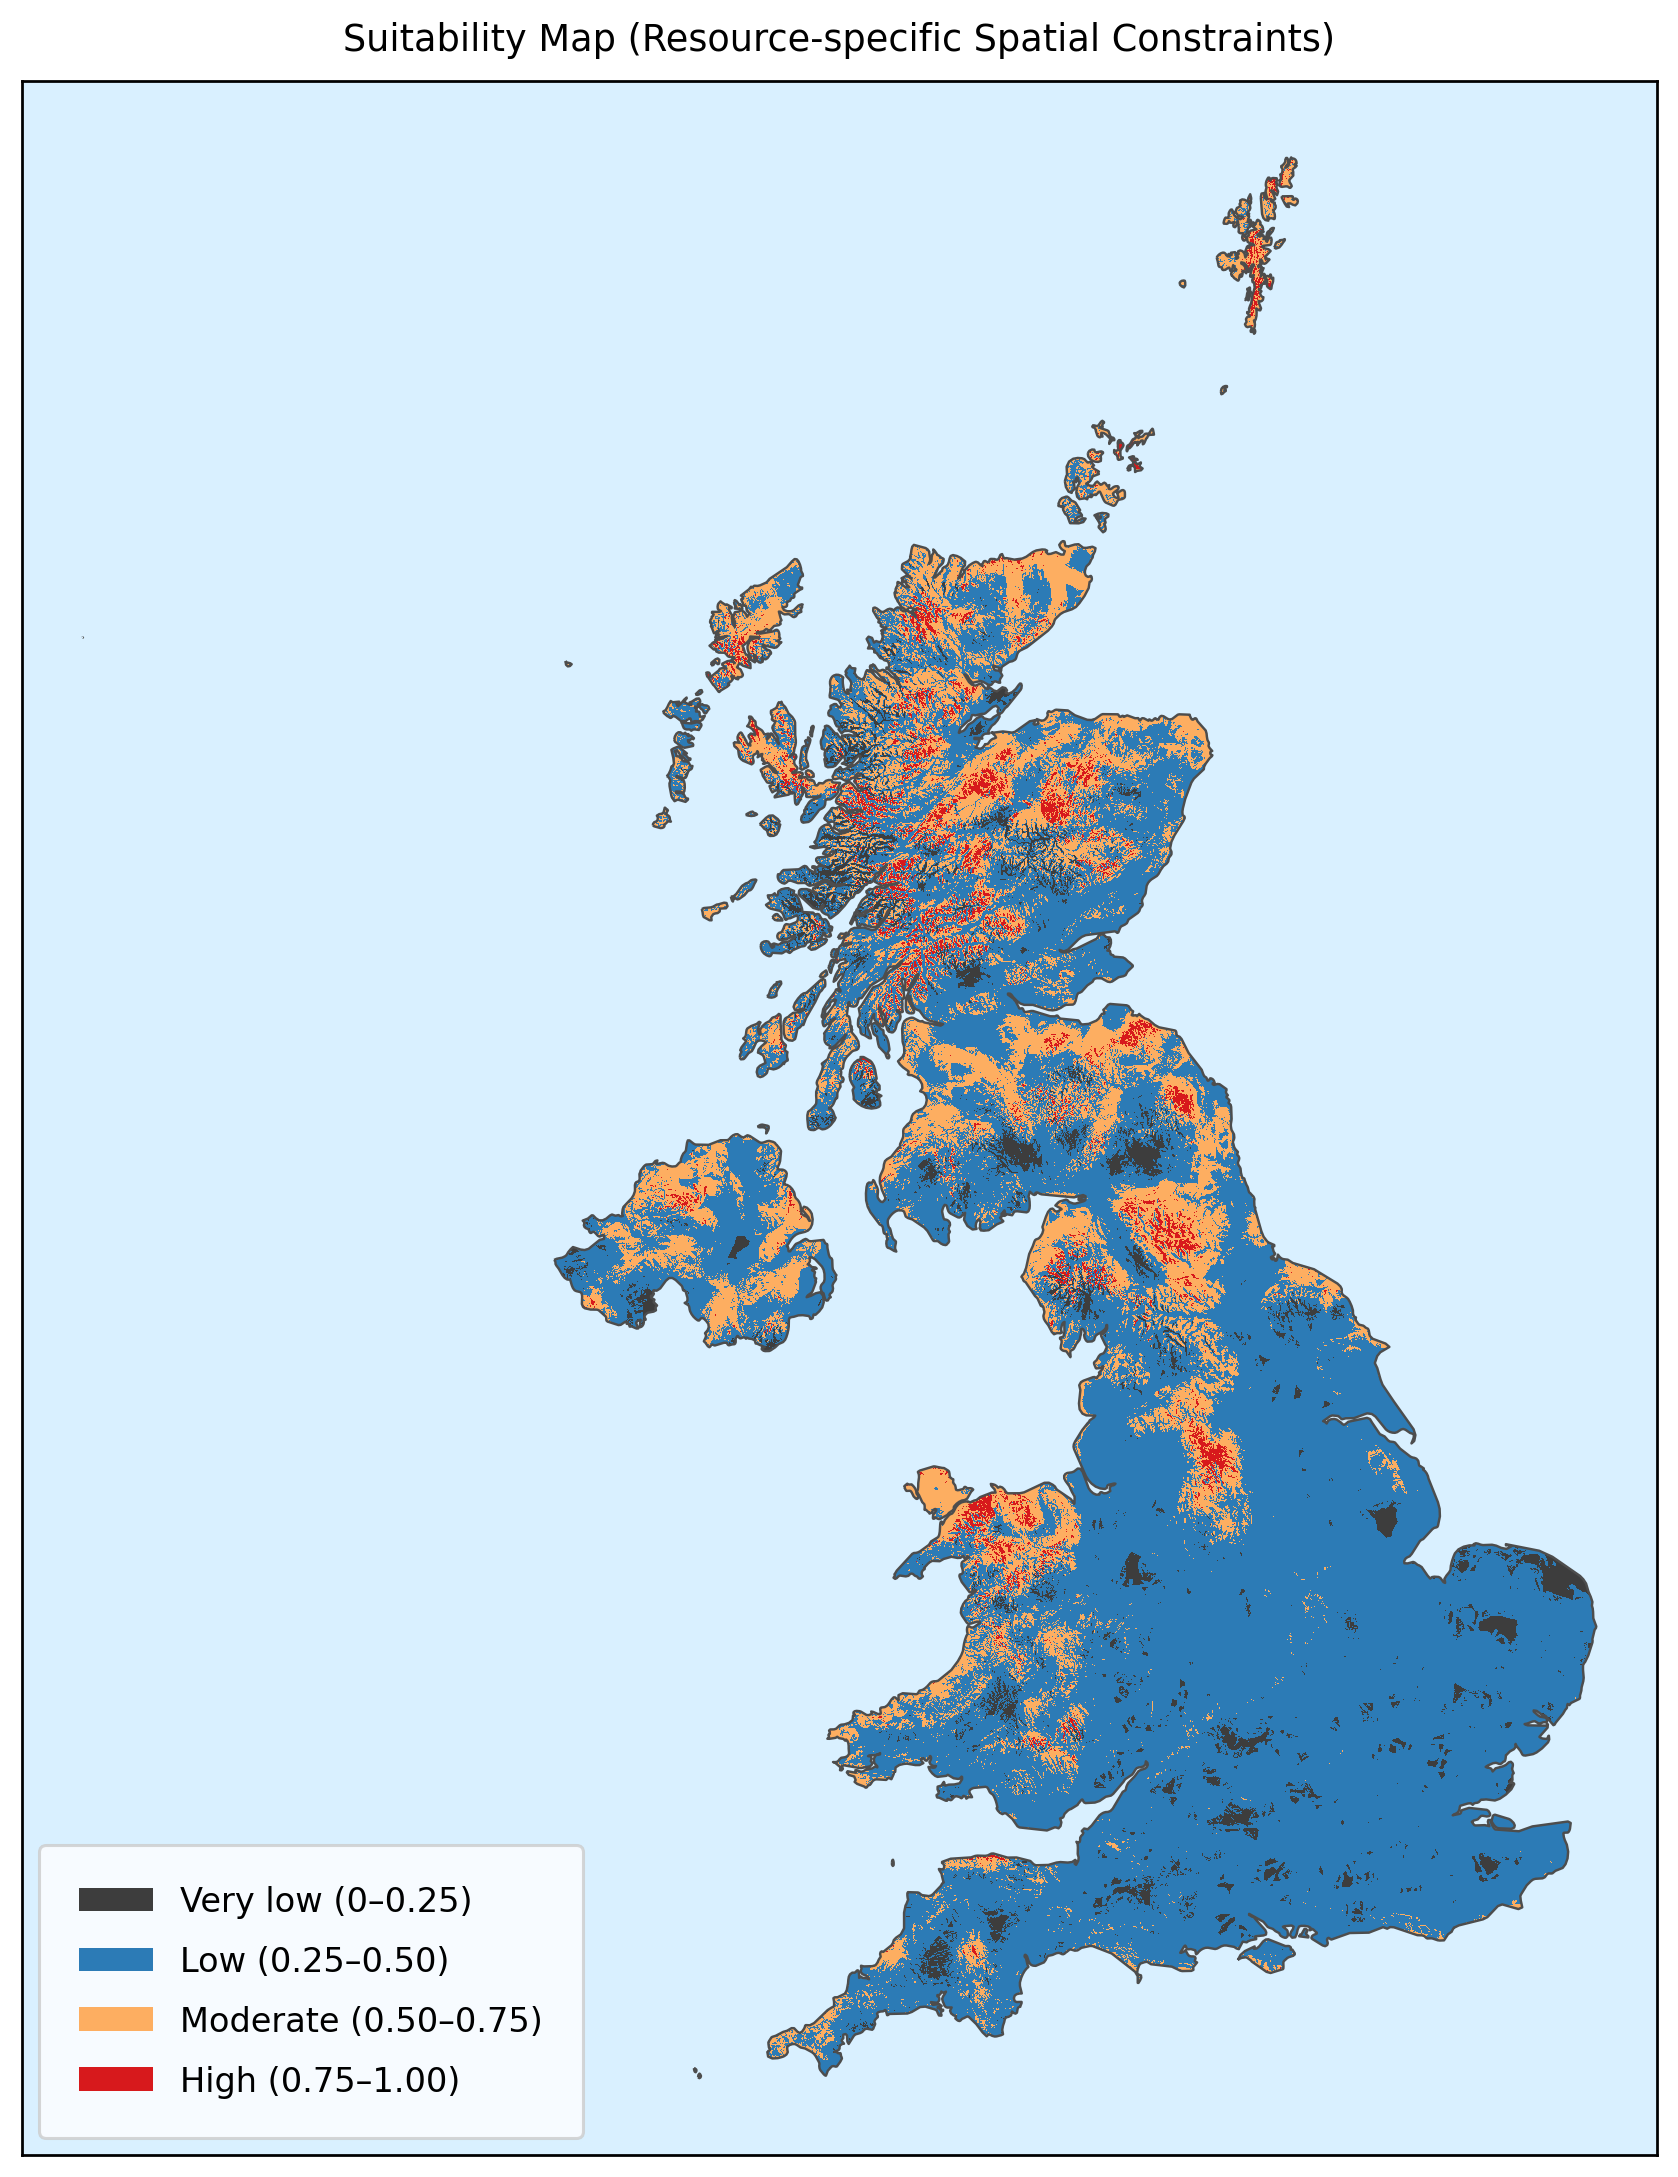

In [16]:
SEA_COLOR = "#d9f0ff"

cmap = ListedColormap(["#3d3d3d", "#2c7bb6", "#fdae61", "#d7191c"])
cmap.set_bad((0, 0, 0, 0))
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plot_arr = cls.astype("float32")
plot_arr[plot_arr == 255] = np.nan

left = tpl_transform.c
top = tpl_transform.f
px_w = tpl_transform.a
px_h = tpl_transform.e
H, W = plot_arr.shape
right = left + W * px_w
bottom = top + H * px_h
extent = (left, right, bottom, top)

fig, ax = plt.subplots(1, 1, figsize=(8, 10), dpi=220)
ax.set_facecolor(SEA_COLOR)

ax.imshow(
    plot_arr,
    cmap=cmap,
    norm=norm,
    extent=extent,
    interpolation="nearest",
    zorder=1
)

if USE_UK:
    world = gpd.read_file(WORLD_SHP)
    if "ADM0_A3" in world.columns:
        uk = world[world["ADM0_A3"].astype(str).str.upper() == "GBR"].dissolve()
    elif "ISO_A3" in world.columns:
        uk = world[world["ISO_A3"].astype(str).str.upper() == "GBR"].dissolve()
    else:
        uk = world[world["ADMIN"].astype(str).str.contains("United Kingdom", case=False, na=False)].dissolve()

    uk = uk.to_crs(tpl_crs)
    uk.boundary.plot(ax=ax, color="#4d4d4d", linewidth=0.8, zorder=3)

    minx, miny, maxx, maxy = uk.total_bounds
    dx, dy = (maxx - minx), (maxy - miny)
    padx, pady = dx * 0.04, dy * 0.04
    ax.set_xlim(minx - padx, maxx + padx)
    ax.set_ylim(miny - pady, maxy + pady)

ax.set_aspect("equal", adjustable="box")
ax.set_title("Suitability Map (Resource-specific Spatial Constraints)", fontsize=12, pad=10)

legend_items = [
    Patch(facecolor=cmap(0), label="Very low (0–0.25)"),
    Patch(facecolor=cmap(1), label="Low (0.25–0.50)"),
    Patch(facecolor=cmap(2), label="Moderate (0.50–0.75)"),
    Patch(facecolor=cmap(3), label="High (0.75–1.00)"),
]
ax.legend(handles=legend_items, loc="lower left", fontsize=11, frameon=True,
          borderpad=1.2, labelspacing=0.8, handlelength=2.2)

ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()
fig.savefig("Suitability Map (Resource-specific Spatial Constraints).png", dpi=300, bbox_inches="tight")